# Two Technical Test 
## Notebook 3/3 Preprocessing and modelling

by: __Alexander Cox__

This notebook contains the steps I took to ensure my data is clean, so that the data that fit my models is as accurate as possible. I will be binarising columns, removing/creating features, running test and train models in an XGBoost Classifier and optimising the hyperparameters to improve the XGBoost classifcation.

__Notebook Contents__

1. [Data Split](#dat)
2. [Handle missing values](#mis)
3. [Define dependent and independent variables](#div)
4. [Model training](#mod)
5. [Evaluate model performace](#eva)
6. [Hyperparameter tuning](#hyp)
7. [Build final model](#fin)
8. [Feature importance](#fea)
9. [Actionable insights and recommendations](#air)

In [103]:
# Import the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [61]:
# Load the CSV file as df.
df = pd.read_csv('tillit_cleaned.csv')

In [62]:
# View the datatypes
data_types = df.dtypes
print(data_types)

Unnamed: 0                      int64
borrower_id                     int64
loan_amnt                     float64
term                           object
emp_title                      object
                               ...   
tax_liens                       int64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 79, dtype: object


<a id='dat'></a>
## Data Split


Firstly, as seen previously there are categorical and numerical columns in the dataframe. I want to split those up into their own lists:

In [63]:
cat_list = list(df.select_dtypes("object").columns)
num_list = list(df.select_dtypes("number").columns)

In [8]:
# View the categorical dataypes
cat_list

['term',
 'emp_title',
 'home_ownership',
 'purpose',
 'addr_state',
 'earliest_cr_line']

### Convert categorical variables into numerical values 

In [64]:
# Label encoding categorical datatypes from the dataframe
# Each of the categories will be assigned a unique integer. XGBoost will handle numerical inputs directly.
# Emp_title will be dropped from the dataframe
label_encoders = {}
for col in ['term', 'home_ownership', 'purpose', 'addr_state', 'earliest_cr_line']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [65]:
# View the numerical dataypes
num_list

['Unnamed: 0',
 'borrower_id',
 'loan_amnt',
 'emp_length',
 'annual_inc',
 'outcome',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_act

Drop the unneccessary columns

In [66]:
# I have chosen to drop the following unnecessary columns as they will not impact the prediction
df.drop(columns=['Unnamed: 0', 'borrower_id', 'emp_title'], inplace=True)


In [67]:
# View the encoded dataframe with the dropped columns before further processing
df

,loan_amnt,term,emp_length,home_ownership,annual_inc,outcome,purpose,addr_state,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,16075.0,1,0.0,1,50289.0,1,4,39,12.27,0,...,0.0,2.0,95.7,100.0,0.0,0,227376.0,15756.0,11900.0,6000.0
1,8000.0,0,10.0,1,64000.0,1,2,14,19.93,0,...,0.0,0.0,100.0,75.0,1.0,0,121881.0,33618.0,13700.0,29400.0
2,23700.0,0,3.0,5,88000.0,1,2,9,29.80,0,...,0.0,5.0,100.0,10.0,1.0,0,99201.0,58898.0,18700.0,69501.0
3,1200.0,0,0.0,1,81000.0,1,9,33,12.87,1,...,0.0,4.0,83.3,100.0,0.0,0,203983.0,20609.0,1100.0,26183.0
4,3500.0,0,0.0,5,11736.0,1,2,46,31.39,0,...,0.0,1.0,100.0,100.0,1.0,0,16200.0,9459.0,2000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,18000.0,1,0.0,5,70000.0,1,2,33,12.72,0,...,0.0,1.0,100.0,33.3,0.0,0,33000.0,20719.0,16000.0,15000.0
40996,23275.0,0,2.0,1,75036.0,1,2,26,3.79,0,...,0.0,4.0,96.0,66.7,0.0,0,149805.0,19222.0,18706.0,0.0
40997,1775.0,0,7.0,5,25000.0,1,11,33,29.43,0,...,0.0,1.0,100.0,66.7,0.0,0,30330.0,23322.0,13300.0,15530.0
40998,15000.0,0,3.0,1,80000.0,1,2,44,9.74,0,...,0.0,1.0,96.7,100.0,0.0,0,444800.0,23436.0,18400.0,0.0


<a id='mis'></a>
## Handle missing values


In [68]:
# Filter out columns with missing data
# Determine the number of missing values 
missing_data = df.isnull().sum()
print(missing_data)


loan_amnt                        0
term                             0
emp_length                       0
home_ownership                   0
annual_inc                       0
                              ... 
tax_liens                        0
tot_hi_cred_lim               2404
total_bal_ex_mort             1649
total_bc_limit                1649
total_il_high_credit_limit    2404
Length: 76, dtype: int64


In [69]:
# Show all columns with missing data 
missing_data = missing_data[missing_data > 0]

# Print columns with missing data
if len(missing_data) > 0:
    print("Columns with missing data:")
    print(missing_data)
else:
    print("No missing data found in the dataset.")

Columns with missing data:
mths_since_last_delinq            21154
mths_since_last_record            34184
revol_util                           24
mths_since_last_major_derog       30349
tot_coll_amt                       2404
tot_cur_bal                        2404
open_acc_6m                       27678
open_act_il                       27678
open_il_12m                       27678
open_il_24m                       27678
mths_since_rcnt_il                28014
total_bal_il                      27678
il_util                           29355
open_rv_12m                       27678
open_rv_24m                       27678
max_bal_bc                        27678
all_util                          27680
total_rev_hi_lim                   2404
inq_fi                            27678
total_cu_tl                       27678
inq_last_12m                      27678
acc_open_past_24mths               1649
avg_cur_bal                        2404
bc_open_to_buy                     2099
bc_util      

I will handle the missing values by imputing the median.

In [70]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [71]:
# View the updated dataframe
df

,loan_amnt,term,emp_length,home_ownership,annual_inc,outcome,purpose,addr_state,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,16075.0,1.0,0.0,1.0,50289.0,1.0,4.0,39.0,12.27,0.0,...,0.0,2.0,95.7,100.0,0.0,0.0,227376.0,15756.0,11900.0,6000.0
1,8000.0,0.0,10.0,1.0,64000.0,1.0,2.0,14.0,19.93,0.0,...,0.0,0.0,100.0,75.0,1.0,0.0,121881.0,33618.0,13700.0,29400.0
2,23700.0,0.0,3.0,5.0,88000.0,1.0,2.0,9.0,29.80,0.0,...,0.0,5.0,100.0,10.0,1.0,0.0,99201.0,58898.0,18700.0,69501.0
3,1200.0,0.0,0.0,1.0,81000.0,1.0,9.0,33.0,12.87,1.0,...,0.0,4.0,83.3,100.0,0.0,0.0,203983.0,20609.0,1100.0,26183.0
4,3500.0,0.0,0.0,5.0,11736.0,1.0,2.0,46.0,31.39,0.0,...,0.0,1.0,100.0,100.0,1.0,0.0,16200.0,9459.0,2000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,18000.0,1.0,0.0,5.0,70000.0,1.0,2.0,33.0,12.72,0.0,...,0.0,1.0,100.0,33.3,0.0,0.0,33000.0,20719.0,16000.0,15000.0
40996,23275.0,0.0,2.0,1.0,75036.0,1.0,2.0,26.0,3.79,0.0,...,0.0,4.0,96.0,66.7,0.0,0.0,149805.0,19222.0,18706.0,0.0
40997,1775.0,0.0,7.0,5.0,25000.0,1.0,11.0,33.0,29.43,0.0,...,0.0,1.0,100.0,66.7,0.0,0.0,30330.0,23322.0,13300.0,15530.0
40998,15000.0,0.0,3.0,1.0,80000.0,1.0,2.0,44.0,9.74,0.0,...,0.0,1.0,96.7,100.0,0.0,0.0,444800.0,23436.0,18400.0,0.0


In [72]:
# Save the updated cleaned dataframe as a csv file.
df.to_csv('df_cleaned.csv')

In [73]:
#  Print the updated missing values 
missing_data1 = df.isnull().sum()
print(missing_data1)

loan_amnt                     0
term                          0
emp_length                    0
home_ownership                0
annual_inc                    0
                             ..
tax_liens                     0
tot_hi_cred_lim               0
total_bal_ex_mort             0
total_bc_limit                0
total_il_high_credit_limit    0
Length: 76, dtype: int64


In [74]:
# Show all columns with missing data 
missing_data1 = missing_data1[missing_data1 > 0]

# Print columns with missing data
if len(missing_data1) > 0:
    print("Columns with missing data:")
    print(missing_data1)
else:
    print("No missing data found in the dataset.")

No missing data found in the dataset.


The data is now ready for the model

<a id='div'></a>
## Define Independent and Dependent Variables

Before I can conduct any modelling I first need to split the data into a Train and Test set. In machine learning, data splitting is typically done to avoid overfitting. That is an instance where a machine learning model fits its training data too well and fails to reliably fit additional data.

In [75]:
# Split dataset into features and target variable
var_columns = [c for c in df.columns if c not in ['outcome']]
X = df.drop(columns=['outcome'])
y = df['outcome']

In [76]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32800, 75), (8200, 75), (32800,), (8200,))

In [77]:
# Identify parameters which can be tuned for XGBoost classifier
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

## Feature Scaling

Scale the input features before feeding them into the XGBoost model. 
This is important because XGBoost, like many machine learning algorithms, can be sensitive to the scale of input features.

In [78]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id='mod'></a>
## Model Training

Train the XGBoost model to have a maximum depth of 15 for each tree in the model.
n_estimators refers to the maximum number of trees. A subsample of 0.5 to have 50% of the observations in the training data set to be randomly selected for creating each individual tree in the model and every hydration will have a different sample of observations. It trains the model quickly and will prevent the model from overfitting. 
While the model is being trained it will be evaluated using 'area under the curve' as a metric.

If the model performance does not change on the validation set for 15 hydrations then the training will stop and the no more trees will be built.  Verbosity is set to true so I can see the output as the model is being trained.

In [79]:
# Train XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1,
                          max_depth = 15,
                          subsample = 0.5,
                          n_estimators=5000,
                          eval_metric='auc',
                          verbosity=1)

eval_set = [(X_test, y_test)]

model.fit(X_train, 
          y_train,
          early_stopping_rounds=15,
          eval_set=eval_set,
          verbose=True)

[0]	validation_0-auc:0.54278
[1]	validation_0-auc:0.58001


C:\Users\alexc_dra7fx5\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.56980
[3]	validation_0-auc:0.58554
[4]	validation_0-auc:0.59815
[5]	validation_0-auc:0.59705
[6]	validation_0-auc:0.59682
[7]	validation_0-auc:0.60156
[8]	validation_0-auc:0.60033
[9]	validation_0-auc:0.59851
[10]	validation_0-auc:0.59750
[11]	validation_0-auc:0.58688
[12]	validation_0-auc:0.59627
[13]	validation_0-auc:0.60171
[14]	validation_0-auc:0.60261
[15]	validation_0-auc:0.59884
[16]	validation_0-auc:0.60700
[17]	validation_0-auc:0.61020
[18]	validation_0-auc:0.61234
[19]	validation_0-auc:0.60935
[20]	validation_0-auc:0.61138
[21]	validation_0-auc:0.61502
[22]	validation_0-auc:0.61189
[23]	validation_0-auc:0.60848
[24]	validation_0-auc:0.60826
[25]	validation_0-auc:0.61107
[26]	validation_0-auc:0.61533
[27]	validation_0-auc:0.61833
[28]	validation_0-auc:0.61630
[29]	validation_0-auc:0.62044
[30]	validation_0-auc:0.62197
[31]	validation_0-auc:0.62174
[32]	validation_0-auc:0.62245
[33]	validation_0-auc:0.61944
[34]	validation_0-auc:0.62153
[35]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<a id='eva'></a>
## Evaluate Model Performance

In [80]:
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(train_auc, test_auc))

AUC Train: 0.9999
AUC Test: 0.6269


The model's performance on the training data is significantly better than its performance on a separate test dataset, this suggests that the model is overfitting.

This indicates that the model has memorized the training data instead of learning generalisable patterns.

The model is unable to generalise well to unseen data.

<a id='hyp'></a>
## Hyperparameter Tuning

Use the GridSearchCV to increase the performance of the model by tuning the hyperparameters.  GridsearchCV tries all possible combinations of hyperparameters that are specified and give the result of model performance by giving a cross-validation technique to give the best set of hyperparameters that can be used.

In [82]:
learning_rate_list =[0.02, 0.05, 0.1]
max_depth_list = [2, 5, 10, 15]
n_estimators_list = [500, 1000, 2000]

params_dict = {"learning_rate": learning_rate_list,
              "max_depth": max_depth_list,
              "n_estimators": n_estimators_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v)

print(num_combinations)
params_dict

36


{'learning_rate': [0.02, 0.05, 0.1],
 'max_depth': [2, 5, 10, 15],
 'n_estimators': [500, 1000, 2000]}

There are 36 different combinations of hyperparameters that will be tried.  Using the hyperparameters which have been defined in the dictionary they will be cross validated (cv) into 2 folds.  This will give two hydrations of the data, the first part will be used for training and the second will be for validation. The second hydration will be vice versa.  A low CV has been selected for speed purposes.

I would have like to increase the CV and number of hyperparameters to modify to be able to optimise the best model.  However, using GridSearch CV to run a high number of combinations can take many hours to perform

In [83]:
# This takes 15+ mins to run
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_hp = GridSearchCV(estimator=xgb.XGBClassifier(subsample=0.5),
                                param_grid=params_dict,
                                cv=2,
                                scoring=my_roc_auc_score,
                                return_train_score=True,
                                verbose=4)

model_hp.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=500;, score=(train=0.808, test=0.667) total time=   0.8s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=500;, score=(train=0.809, test=0.646) total time=   0.8s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.866, test=0.663) total time=   1.5s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.857, test=0.644) total time=   1.7s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.923, test=0.649) total time=   3.6s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.912, test=0.633) total time=   3.2s
[CV 1/2] END learning_rate=0.02, max_depth=5, n_estimators=500;, score=(train=0.990, test=0.642) total time=   1.5s
[CV 2/2] END learning_rate=0.02, max_depth=5, n_estimators=500;, score=(train=0.987, test=0.635) total time=   1.6s
[CV 1/2

[CV 1/2] END learning_rate=0.1, max_depth=15, n_estimators=2000;, score=(train=1.000, test=0.592) total time=  16.4s
[CV 2/2] END learning_rate=0.1, max_depth=15, n_estimators=2000;, score=(train=1.000, test=0.596) total time=  20.1s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [2, 5, 10, 15],
                         'n_estimators': [500, 1000, 2000]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x000002B3D1DFAF20>,
             verbose=4)

Create a dataframe to show the results by mean test score of the cross validation hyperparameter tuning.  The highest result will be used to create the optimised model.

In [84]:
# View the results of the cross validation hyperparameter tuning
cv_results = pd.DataFrame(model_hp.cv_results_)
cv_results = cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
0,1,0.656168,0.808219,0.02,2,500
1,2,0.653466,0.861207,0.02,2,1000
12,3,0.647573,0.875425,0.05,2,500
2,4,0.641256,0.917143,0.02,2,2000
13,5,0.639291,0.929179,0.05,2,1000
3,6,0.638336,0.988275,0.02,5,500
24,7,0.634970,0.918610,0.1,2,500
9,8,0.628402,1.000000,0.02,15,500
25,9,0.623491,0.967994,0.1,2,1000
6,10,0.623400,0.999997,0.02,10,500


The best result on the test model is 0.656168 I can use this combination of hyperparameters to build a final model to get a better XGBoost classifier with better performance on the validation set 

Text(0.5, 1.0, 'Performance with reference to number of Trees and Depth')

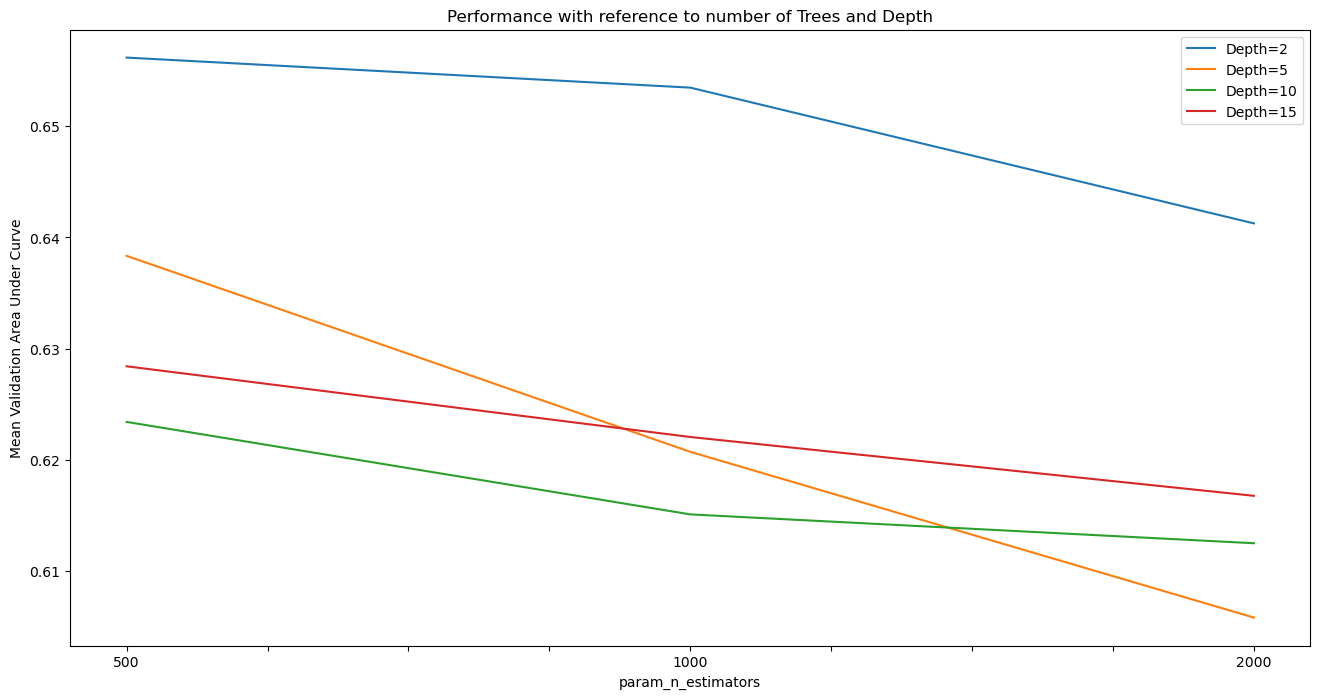

In [85]:
# First sort by number of estimators as that would be x-axis
cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find the values of area under the curve for learning rate of 0.02 and different values of depth
lr_d2 = cv_results.loc[(cv_results['param_learning_rate']==0.02) & (cv_results['param_max_depth']==2),:]
lr_d5 = cv_results.loc[(cv_results['param_learning_rate']==0.02) & (cv_results['param_max_depth']==5),:]
lr_d10 = cv_results.loc[(cv_results['param_learning_rate']==0.02) & (cv_results['param_max_depth']==10),:]
lr_d15 = cv_results.loc[(cv_results['param_learning_rate']==0.02) & (cv_results['param_max_depth']==15),:]

# Create a lineplot of the results
fig, ax = plt.subplots(figsize=(16,8))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
lr_d10.plot(x='param_n_estimators', y='mean_test_score', label='Depth=10', ax=ax)
lr_d15.plot(x='param_n_estimators', y='mean_test_score', label='Depth=15', ax=ax)
plt.ylabel('Mean Validation Area Under Curve')
plt.title('Performance with reference to number of Trees and Depth')

Now that I have seen the performance is higher for lower values of trees I will find performance with respect to learning rate. I fix n_estimators to 500 and depth to 2.

Text(0.5, 1.0, 'Performance with respect to learning rate')

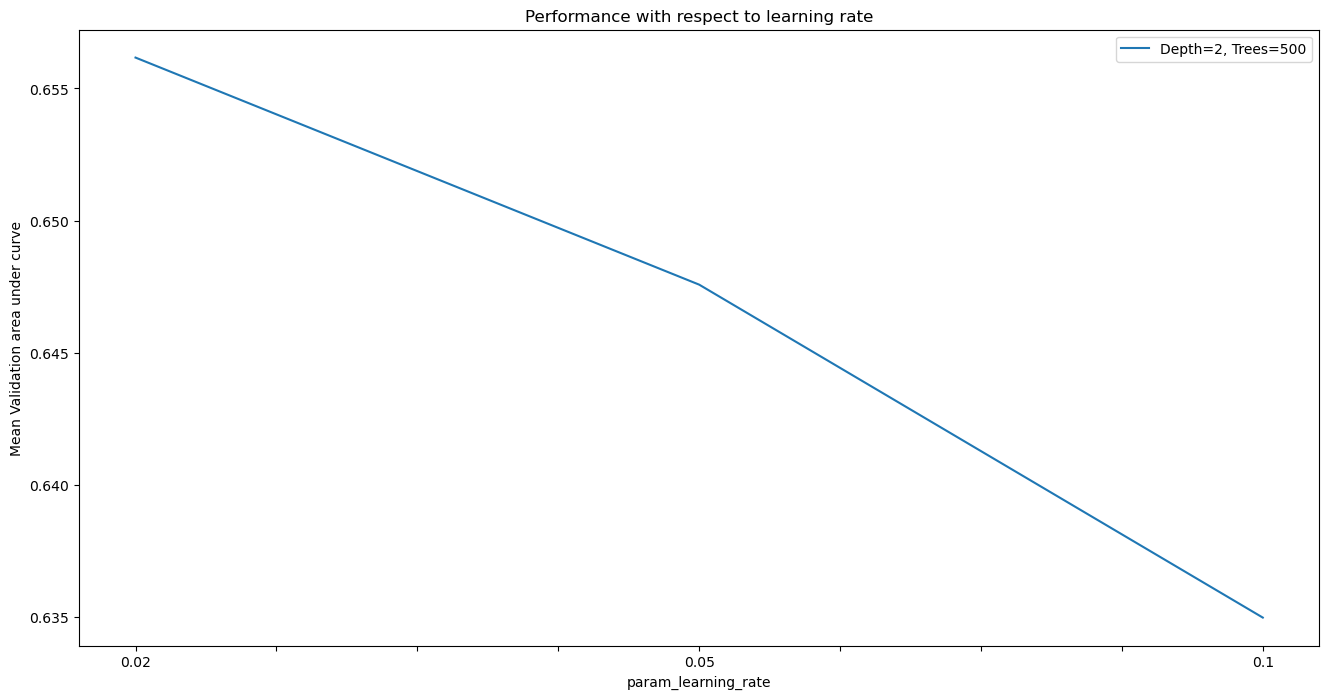

In [87]:
# First sort by learning rate as that would be x-axis
cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.02 and different values of depth
lr_d2_n = cv_results.loc[(cv_results['param_n_estimators']==500) & (cv_results['param_max_depth']==2),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(16,8))
lr_d2_n .plot(x='param_learning_rate', y='mean_test_score', label='Depth=2, Trees=500', ax=ax)
plt.ylabel('Mean Validation area under curve')
plt.title('Performance with respect to learning rate')

<a id='fin'></a>
## Build final model

Build the final model with the best hyperparameters discovered from the tuning process to produce an optimised model

In [88]:
model_fin = xgb.XGBClassifier(learning_rate=0.02,
                                          max_depth=2,
                                          n_estimators=500,
                                          eval_metric='auc',
                                          verbosity=1)

# Passing both training and validation dataset as we want to plot the area under curve for both
eval_set = [(X_train, y_train),(X_test, y_test)]

model_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.60255	validation_1-auc:0.61721
[1]	validation_0-auc:0.60639	validation_1-auc:0.62174
[2]	validation_0-auc:0.60639	validation_1-auc:0.62174
[3]	validation_0-auc:0.60639	validation_1-auc:0.62174
[4]	validation_0-auc:0.60639	validation_1-auc:0.62174
[5]	validation_0-auc:0.60646	validation_1-auc:0.62310
[6]	validation_0-auc:0.60644	validation_1-auc:0.62381
[7]	validation_0-auc:0.60646	validation_1-auc:0.62310
[8]	validation_0-auc:0.61118	validation_1-auc:0.62714
[9]	validation_0-auc:0.61105	validation_1-auc:0.62658
[10]	validation_0-auc:0.61118	validation_1-auc:0.62714


C:\Users\alexc_dra7fx5\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-auc:0.61118	validation_1-auc:0.62714
[12]	validation_0-auc:0.61105	validation_1-auc:0.62658
[13]	validation_0-auc:0.61118	validation_1-auc:0.62714
[14]	validation_0-auc:0.61152	validation_1-auc:0.62737
[15]	validation_0-auc:0.61145	validation_1-auc:0.62719
[16]	validation_0-auc:0.61150	validation_1-auc:0.62734
[17]	validation_0-auc:0.61152	validation_1-auc:0.62737
[18]	validation_0-auc:0.61152	validation_1-auc:0.62737
[19]	validation_0-auc:0.61150	validation_1-auc:0.62734
[20]	validation_0-auc:0.61152	validation_1-auc:0.62737
[21]	validation_0-auc:0.61152	validation_1-auc:0.62737
[22]	validation_0-auc:0.62623	validation_1-auc:0.63524
[23]	validation_0-auc:0.62628	validation_1-auc:0.63510
[24]	validation_0-auc:0.63391	validation_1-auc:0.65087
[25]	validation_0-auc:0.63388	validation_1-auc:0.65084
[26]	validation_0-auc:0.63359	validation_1-auc:0.64526
[27]	validation_0-auc:0.63359	validation_1-auc:0.64536
[28]	validation_0-auc:0.63390	validation_1-auc:0.65098
[29]	valid

[159]	validation_0-auc:0.69303	validation_1-auc:0.68252
[160]	validation_0-auc:0.69354	validation_1-auc:0.68279
[161]	validation_0-auc:0.69426	validation_1-auc:0.68279
[162]	validation_0-auc:0.69464	validation_1-auc:0.68297
[163]	validation_0-auc:0.69473	validation_1-auc:0.68348
[164]	validation_0-auc:0.69527	validation_1-auc:0.68362
[165]	validation_0-auc:0.69576	validation_1-auc:0.68383
[166]	validation_0-auc:0.69566	validation_1-auc:0.68427
[167]	validation_0-auc:0.69615	validation_1-auc:0.68397
[168]	validation_0-auc:0.69656	validation_1-auc:0.68416
[169]	validation_0-auc:0.69716	validation_1-auc:0.68433
[170]	validation_0-auc:0.69776	validation_1-auc:0.68459
[171]	validation_0-auc:0.69748	validation_1-auc:0.68460
[172]	validation_0-auc:0.69780	validation_1-auc:0.68467
[173]	validation_0-auc:0.69827	validation_1-auc:0.68480
[174]	validation_0-auc:0.69877	validation_1-auc:0.68435
[175]	validation_0-auc:0.69879	validation_1-auc:0.68487
[176]	validation_0-auc:0.69919	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The final XGBoost classifier has produced 267 trees.  Now I want to look at the area under the curve values for the training and test dataset.

In [89]:
# Review the training and test performance
y_train_pred_fin = model_fin.predict_proba(X_train)[:, 1]
y_test_pred_fin = model_fin.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_fin)
test_auc = roc_auc_score(y_test, y_test_pred_fin)

print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(train_auc, test_auc))

AUC Train: 0.7204
AUC Test: 0.6888


The AUC test performance has increased to 0.688 from 0.6234 by tuning the hyperparameters. 

Calculate the train and test accuracy results of the models

In [90]:
# Assuming threshold of 0.5 for binary classification
y_train_pred_labels = (y_train_pred_fin >= 0.5).astype(int)
y_test_pred_labels = (y_test_pred_fin >= 0.5).astype(int)

train_accuracy = np.mean(y_train == y_train_pred_labels)
test_accuracy = np.mean(y_test == y_test_pred_labels)

print("Accuracy Train: {:.4f}\nAccuracy Test: {:.4f}".format(train_accuracy, test_accuracy))

Accuracy Train: 0.9758
Accuracy Test: 0.9748


The accuracy of the train and test models are 0.9758 and 0.9748. 
An accuracy score of assumes that 97.5% of the predictions made by the model are correct. The model accurately predicts the outcome for 97.5% of them.

This high accuracy score suggests that the model performs very well on the given dataset.

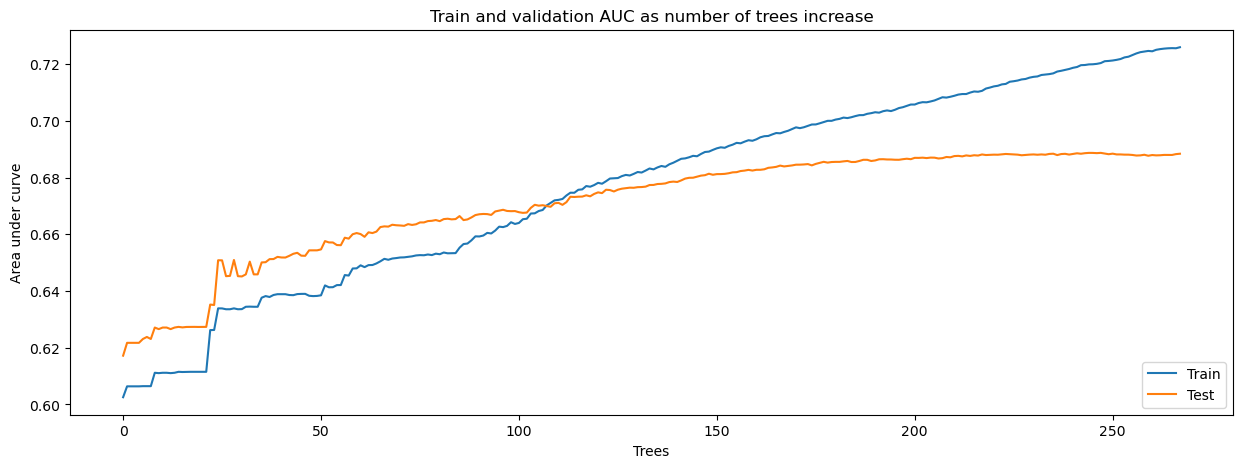

In [91]:
evaluation_results = model_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
test_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(test_auc_tree, label='Test')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("Area under curve")
plt.legend(loc='lower right')
plt.show()

There is a large separation between the train and test data which suggests that the model is overfitting.  To mitigate this fewer features would need to be selected to remove noisy and irrelevant features and enhanced cross validation will need to be performed.

<a id='fea'></a>
## Feature Importance

I would like to determine which feature are the most important to build the model.

In [144]:
df_var_imp = pd.DataFrame({"Feature": var_columns,
                           "Importance": model_fin.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:15]

,Feature,Importance
41,bc_util,0.036998
74,total_il_high_credit_limit,0.035718
71,tot_hi_cred_lim,0.031600
0,loan_amnt,0.031075
9,earliest_cr_line,0.030382
73,total_bc_limit,0.030217
16,revol_util,0.030040
44,mo_sin_old_il_acct,0.029760
48,mort_acc,0.029462
1,term,0.029287


Using feature_importance I have found out that the following features are the most important to determine whether the applicant will fully pay or default on their loan from the inital dataset
- bc_util, Ratio of total current balance to high credit/credit limit for all bankcard accounts.
- total_il_high_credit_limit, Total installment high credit/credit limit
- tot_hi_cred_lim, Total high credit/credit limit
- loan_amnt, The loan amount
- earliest_cr_line, earliest_cr_line


## Use the test data model to predict the outcome of the loan

In [47]:
# Import cleaneddf
df_test = pd.read_csv('df_cleaned.csv')

df_test.shape

(41000, 77)

In [48]:
# Test the model to predict the outcome of the current data set
X_test = df_test.loc[:, var_columns]

df_test['outcome'] = model_fin.predict_proba(X_test)[:,1]
df_test

,Unnamed: 0,loan_amnt,term,emp_length,home_ownership,annual_inc,outcome,purpose,addr_state,dti,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0,16075.0,1.0,0.0,1.0,50289.0,0.948157,4.0,39.0,12.27,...,0.0,2.0,95.7,100.0,0.0,0.0,227376.0,15756.0,11900.0,6000.0
1,1,8000.0,0.0,10.0,1.0,64000.0,0.960928,2.0,14.0,19.93,...,0.0,0.0,100.0,75.0,1.0,0.0,121881.0,33618.0,13700.0,29400.0
2,2,23700.0,0.0,3.0,5.0,88000.0,0.954157,2.0,9.0,29.80,...,0.0,5.0,100.0,10.0,1.0,0.0,99201.0,58898.0,18700.0,69501.0
3,3,1200.0,0.0,0.0,1.0,81000.0,0.951802,9.0,33.0,12.87,...,0.0,4.0,83.3,100.0,0.0,0.0,203983.0,20609.0,1100.0,26183.0
4,4,3500.0,0.0,0.0,5.0,11736.0,0.955781,2.0,46.0,31.39,...,0.0,1.0,100.0,100.0,1.0,0.0,16200.0,9459.0,2000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,40995,18000.0,1.0,0.0,5.0,70000.0,0.956249,2.0,33.0,12.72,...,0.0,1.0,100.0,33.3,0.0,0.0,33000.0,20719.0,16000.0,15000.0
40996,40996,23275.0,0.0,2.0,1.0,75036.0,0.955216,2.0,26.0,3.79,...,0.0,4.0,96.0,66.7,0.0,0.0,149805.0,19222.0,18706.0,0.0
40997,40997,1775.0,0.0,7.0,5.0,25000.0,0.954157,11.0,33.0,29.43,...,0.0,1.0,100.0,66.7,0.0,0.0,30330.0,23322.0,13300.0,15530.0
40998,40998,15000.0,0.0,3.0,1.0,80000.0,0.952727,2.0,44.0,9.74,...,0.0,1.0,96.7,100.0,0.0,0.0,444800.0,23436.0,18400.0,0.0


## Actionable insights and recommendations

After gridsearch optimisation XGBoost model was able to improve the test score of the model. However, the model I feel has overfitted to the training data and this has led to lower scores for the test. I felt that XGBoost would be able to able to perform better than other models and also at a quicker speed. Given it is an ensemble method similar to adaboost and given that is designed to combat bias in the data much more effectively - this was claimed in the XGBoost documentation. Most of the parameters are designed to ensure that the bias is taken into account.

The next steps for this model are that I would like to explore parameters that would control overfitting. Furthermore, lowering the learning rate when conducting xgboost means that you have to increase the num_rounds parameter. This parameter controls the number of rounds for boosting which if I had more time I would like to explore

Using the feature selection importance tool I was able to determine which features were important to build the model with respect to the outcome.  I would like to remove a number of attributes which have little to no importance in building the predictive model to determine whether the applicant would pay back a loan or not. Optimising the feature selection of the model will improve the models performance of both the train and test sets.

With more time and a better performing predictive model I would have used a confusion matrix to describe the performance of a classifcation model. 

For this model I only used 2 cross validation checks mostly for speed purposes.  However, I would like to have increased the now of cross validation as it evaluates the model's generalisation ability on multiple folds of the training data.

Other areas I would have liked to work further on are EDA I was only able to create a number of plots to gain initial insights into the data.  I would have liked to conduct a larger correaltion heatmap between the numerical values to see if there are any strong correlations.

Finally, for the last stage of my EDA I would have liked to use clustering to determine if there are any groups within my data. 

